# Preliminaries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

warnings.filterwarnings('ignore')

C:\Users\Anoshan\AppData\Local\Temp\ipykernel_15840\1588287611.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


Import the data

In [3]:
path = "../Datasets/"
Train = pd.read_csv(path + '/Historical-transaction-data.csv')
StoreInfo = pd.read_csv(path + '/Store-info.csv')
Submission_testing = pd.read_csv(path + '/Testing-data.csv')

Join both datasets to form a train dataset

In [4]:
Train = Train.merge(StoreInfo, on='shop_id', how='left')

In [5]:
Submission_testing.drop("shop_profile", axis=1, inplace=True)
# Submission_testing = Submission_testing.merge(StoreInfo, on='shop_id', how='left')
# Submission_testing.drop("shop_profile", axis=1, inplace=True)
Submission_testing = Submission_testing.merge(Train, on='shop_id', how='left')

In [6]:
Submission_testing.drop("shop_profile", axis=1, inplace=True)

In [7]:
Train.head()

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold,shop_area_sq_ft,shop_profile
0,ORANGE BARLEY 1.5L,2021-12-11T00:00:00.000Z,147.0,BGXA,SHOP008,220,2,678,Moderate
1,GINGER BEER 1.5L,2021-10-17T00:00:00.000Z,371.0,IA25,SHOP112,220,2,668,Moderate
2,TONIC PET 500ML,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,160,2,678,Moderate
3,CREAM SODA 1L,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,150,2,678,Moderate
4,STRAWBERRY MILK 180ML,2021-10-23T00:00:00.000Z,1310.0,7S00,SHOP112,210,5,668,Moderate


In [8]:
Submission_testing.head()

,shop_id,item_description,transaction_date,invoice_id,customer_id,item_price,quantity_sold,shop_area_sq_ft
0,SHOP046,FIT O MIXED FRUIT 1L,2021-10-15T00:00:00.000Z,154826.0,H6RV,270,1,545
1,SHOP046,FIT O ORANGE 1L,2021-10-27T00:00:00.000Z,157798.0,Z1SZ,290,1,545
2,SHOP046,LEMONADE 1.5L,2021-10-28T00:00:00.000Z,157881.0,HFM8,220,2,545
3,SHOP046,FIT O MANGO 200ML,2021-11-03T00:00:00.000Z,159352.0,RFTZ,180,4,545
4,SHOP046,FIT O MIXED FRUIT 200ML,2021-11-03T00:00:00.000Z,159352.0,RFTZ,60,1,545


In [9]:
print("New length: ", Train.shape[0])

New length:  473974


Remove Duplicates

In [10]:
i_length = Train.shape[0]

In [11]:
Train.drop_duplicates(inplace=True)

In [12]:

print("Duplicates dropped from Train: ", i_length - Train.shape[0] )
print("New length: ", Train.shape[0])

Duplicates dropped from Train:  31211
New length:  442763


# Analysis

Missing data

<Axes: >

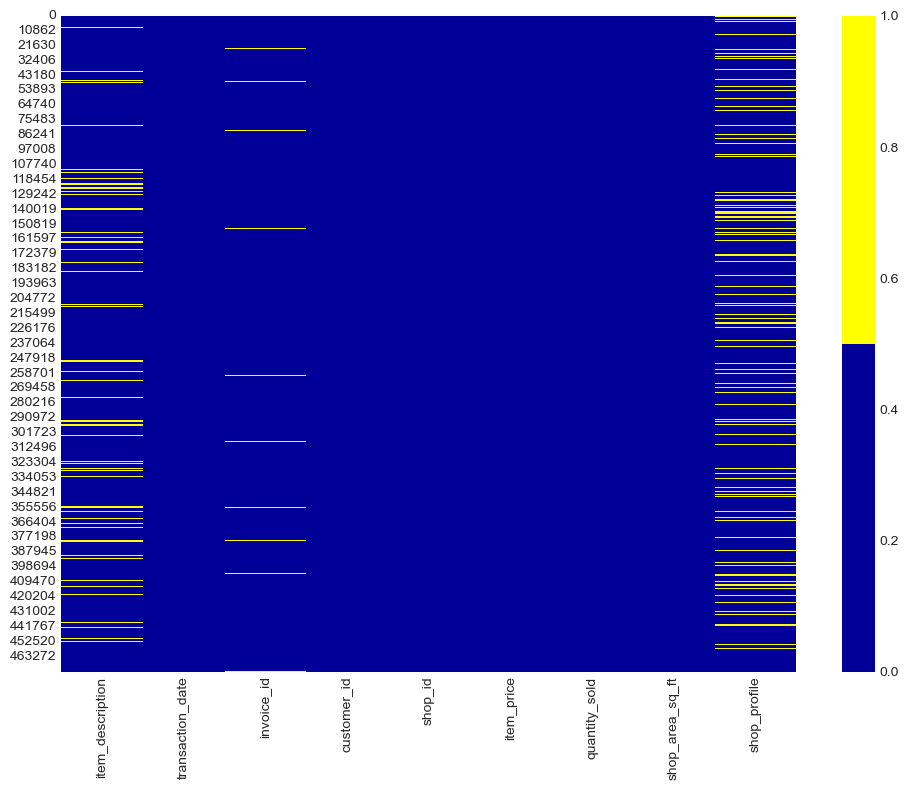

In [13]:
plt.figure(figsize=(10,8))
cols = Train.columns
colours = ['#000099', '#ffff00'] # specify colours: yellow - missing. blue - not missing
sns.heatmap(Train[cols].isna(), cmap=sns.color_palette(colours))

<Axes: >

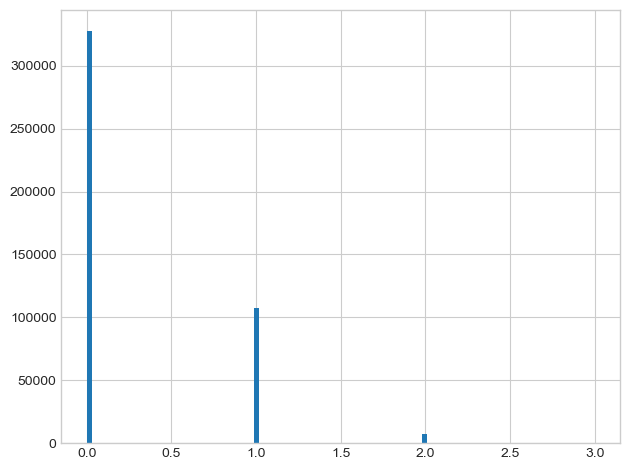

In [14]:
# No. of columns missing for the rows
missing_by_row = Train.isna().sum(axis="columns")
missing_by_row.hist(bins=100)

In [15]:
pct_missing = Train.isna().mean()
pct_missing[:15]

item_description    0.079198
transaction_date    0.000000
invoice_id          0.013030
customer_id         0.000000
shop_id             0.000000
item_price          0.000000
quantity_sold       0.000000
shop_area_sq_ft     0.000000
shop_profile        0.183565
dtype: float64

In [16]:
#Remove rows with null values for item_description or shop_profile
Train = Train.dropna(subset=['item_description', 'shop_profile'], axis=0)

In [17]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332581 entries, 0 to 473973
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   item_description  332581 non-null  object 
 1   transaction_date  332581 non-null  object 
 2   invoice_id        327971 non-null  float64
 3   customer_id       332581 non-null  object 
 4   shop_id           332581 non-null  object 
 5   item_price        332581 non-null  int64  
 6   quantity_sold     332581 non-null  int64  
 7   shop_area_sq_ft   332581 non-null  int64  
 8   shop_profile      332581 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 25.4+ MB


In [18]:
print("New length: ", Train.shape[0])

New length:  332581


Fill Missing Values

In [19]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332581 entries, 0 to 473973
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   item_description  332581 non-null  object 
 1   transaction_date  332581 non-null  object 
 2   invoice_id        327971 non-null  float64
 3   customer_id       332581 non-null  object 
 4   shop_id           332581 non-null  object 
 5   item_price        332581 non-null  int64  
 6   quantity_sold     332581 non-null  int64  
 7   shop_area_sq_ft   332581 non-null  int64  
 8   shop_profile      332581 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 25.4+ MB


Encoding

In [20]:
# Set the data types of each feature

# The nominative (unordered) categorical features
features_nom = ["item_description", "customer_id", "shop_id", "shop_profile"]

for feature in features_nom:
    Train[feature] = Train[feature].astype("category")
    if feature == "shop_profile":
        continue
    Submission_testing[feature] = Submission_testing[feature].astype("category")

Train["transaction_date"] = pd.to_datetime(Train["transaction_date"])

In [21]:
Train_y = Train["shop_profile"]
Train.drop("shop_profile", axis=1, inplace=True)

In [22]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332581 entries, 0 to 473973
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   item_description  332581 non-null  category           
 1   transaction_date  332581 non-null  datetime64[ns, UTC]
 2   invoice_id        327971 non-null  float64            
 3   customer_id       332581 non-null  category           
 4   shop_id           332581 non-null  category           
 5   item_price        332581 non-null  int64              
 6   quantity_sold     332581 non-null  int64              
 7   shop_area_sq_ft   332581 non-null  int64              
dtypes: category(3), datetime64[ns, UTC](1), float64(1), int64(3)
memory usage: 22.3 MB


In [23]:
Train.drop(["invoice_id", "customer_id"], axis=1, inplace=True)
Submission_testing.drop(["invoice_id", "customer_id"], axis=1, inplace=True)

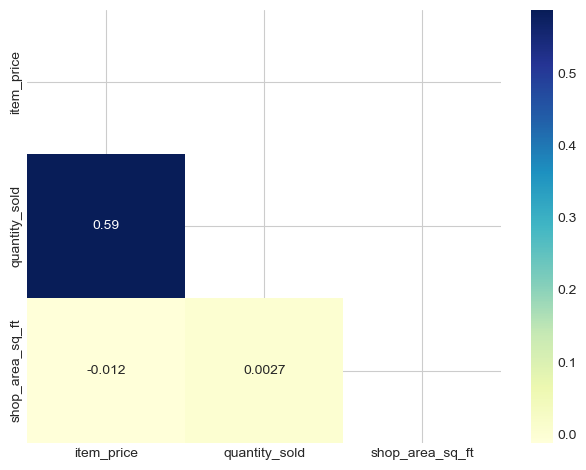

In [24]:
# creating mask
mask = np.triu(np.ones_like(Train.corr()))
 
# plotting a triangle correlation heatmap
dataplot = sns.heatmap(Train.corr(), cmap="YlGnBu", annot=True, mask=mask)
 
# displaying heatmap
plt.show()

In [25]:
# Check for outliers

Train.kurt(numeric_only=True)

item_price         382.227475
quantity_sold      420.507197
shop_area_sq_ft      2.908254
dtype: float64

In [26]:
Train["quantity_sold"].describe()

count    332581.000000
mean          1.874626
std           1.539118
min          -1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max         101.000000
Name: quantity_sold, dtype: float64

In [27]:
# TODO : further investigate the outliers

In [28]:
Train["item_price"].describe()

count    332581.000000
mean        214.825306
std         167.916289
min          35.000000
25%         110.000000
50%         220.000000
75%         220.000000
max       17400.000000
Name: item_price, dtype: float64

In [29]:
Train['timestamp_dt'] = pd.to_datetime(Train['transaction_date'], format='%Y-%m-%d')
Train['year'] = Train['timestamp_dt'].dt.year
Train['month'] = Train['timestamp_dt'].dt.month
Train['weekday'] = Train['timestamp_dt'].dt.weekday

Train.drop(['timestamp_dt', 'transaction_date'], axis=1, inplace=True)

Train.head()

,item_description,shop_id,item_price,quantity_sold,shop_area_sq_ft,year,month,weekday
0,ORANGE BARLEY 1.5L,SHOP008,220,2,678,2021,12,5
1,GINGER BEER 1.5L,SHOP112,220,2,668,2021,10,6
2,TONIC PET 500ML,SHOP008,160,2,678,2021,12,0
3,CREAM SODA 1L,SHOP008,150,2,678,2021,12,0
4,STRAWBERRY MILK 180ML,SHOP112,210,5,668,2021,10,5


In [30]:
Submission_testing['timestamp_dt'] = pd.to_datetime(Submission_testing['transaction_date'], format='%Y-%m-%d')
Submission_testing['year'] = Submission_testing['timestamp_dt'].dt.year
Submission_testing['month'] = Submission_testing['timestamp_dt'].dt.month
Submission_testing['weekday'] = Submission_testing['timestamp_dt'].dt.weekday

Submission_testing.drop(['timestamp_dt', 'transaction_date'], axis=1, inplace=True)

Submission_testing.head()

,shop_id,item_description,item_price,quantity_sold,shop_area_sq_ft,year,month,weekday
0,SHOP046,FIT O MIXED FRUIT 1L,270,1,545,2021,10,4
1,SHOP046,FIT O ORANGE 1L,290,1,545,2021,10,2
2,SHOP046,LEMONADE 1.5L,220,2,545,2021,10,3
3,SHOP046,FIT O MANGO 200ML,180,4,545,2021,11,2
4,SHOP046,FIT O MIXED FRUIT 200ML,60,1,545,2021,11,2


In [31]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Train_y = le.fit_transform(Train_y)

In [32]:
# remove the substring "SHOP" from the shop_id column and convert it to int
Train["shop_id"] = Train["shop_id"].str.replace("SHOP", "").astype(int)
# Train["shop_id"] = Train["shop_id"].str.replace("SHOP", "")
# Train["shop_id"] = Train["shop_id"].astype()")
# convert it to categorical
Train["shop_id"] = Train["shop_id"].astype("category")

In [33]:
# remove the substring "SHOP" from the shop_id column
Submission_testing["shop_id"] = Submission_testing["shop_id"].str.replace("SHOP", "").astype(int)

In [34]:
## Splitting the dataset into the Training set and Test set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Train, Train_y, test_size = 0.2, random_state = 1)

In [35]:
X_train.head()

,item_description,shop_id,item_price,quantity_sold,shop_area_sq_ft,year,month,weekday
13201,SODA 1L,86,110,2,661,2021,10,5
293065,LEMONADE 500ML,37,200,2,717,2021,12,5
63548,LEMONADE 1.5L,66,220,3,470,2021,12,0
466484,GINGER BEER 1.5L,60,220,1,676,2021,10,2
316348,SODA 1L,112,220,3,668,2021,11,0


In [36]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [37]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266064 entries, 13201 to 182378
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   item_description  266064 non-null  category
 1   shop_id           266064 non-null  category
 2   item_price        266064 non-null  int64   
 3   quantity_sold     266064 non-null  int64   
 4   shop_area_sq_ft   266064 non-null  int64   
 5   year              266064 non-null  int64   
 6   month             266064 non-null  int64   
 7   weekday           266064 non-null  int64   
dtypes: category(2), int64(6)
memory usage: 14.7 MB


In [38]:
Submission_testing = Submission_testing[Train.columns]

In [39]:
X_train.head()

,item_description,shop_id,item_price,quantity_sold,shop_area_sq_ft,year,month,weekday
13201,SODA 1L,86,110,2,661,2021,10,5
293065,LEMONADE 500ML,37,200,2,717,2021,12,5
63548,LEMONADE 1.5L,66,220,3,470,2021,12,0
466484,GINGER BEER 1.5L,60,220,1,676,2021,10,2
316348,SODA 1L,112,220,3,668,2021,11,0


In [40]:
# unique values in each column
X_train.nunique()

item_description     37
shop_id             100
item_price          172
quantity_sold        59
shop_area_sq_ft      53
year                  1
month                 3
weekday               7
dtype: int64

In [41]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266064 entries, 13201 to 182378
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   item_description  266064 non-null  category
 1   shop_id           266064 non-null  category
 2   item_price        266064 non-null  int64   
 3   quantity_sold     266064 non-null  int64   
 4   shop_area_sq_ft   266064 non-null  int64   
 5   year              266064 non-null  int64   
 6   month             266064 non-null  int64   
 7   weekday           266064 non-null  int64   
dtypes: category(2), int64(6)
memory usage: 14.7 MB


# Metrics

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


def score_classification(model, df1_x, df1_y, df2_x, df2_y):
  print(model)
  df1_x = df1_x.copy()
  df2_x = df2_x.copy()
  
  ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(handle_unknown='ignore'), [0])], remainder='passthrough')
 
  # One hot encoding for the item_description column

  df1_encoded = ct.fit_transform(df1_x[["item_description"]])
  df1_x = pd.concat([df1_x.drop("item_description", axis=1).reset_index(drop=True), pd.DataFrame(df1_encoded.toarray())], axis='columns')
 
  df2_encoded = ct.transform(df2_x[["item_description"]]) 
  df2_x = pd.concat([df2_x.drop("item_description", axis=1).reset_index(drop=True), pd.DataFrame(df2_encoded.toarray())], axis='columns')    
  
  df1_x.columns = df1_x.columns.astype(str)
  df2_x.columns = df2_x.columns.astype(str)
 
  # Fit the model  
  model.fit(df1_x, df1_y)

  # Make predictions
  y_pred = model.predict(df2_x)

  # Evaluate the model
  accuracy = accuracy_score(df2_y, y_pred)
  precision = precision_score(df2_y, y_pred,  average='macro')
  recall = recall_score(df2_y, y_pred,  average='macro')
  f1 = f1_score(df2_y, y_pred,  average='macro')

  print(f"Accuracy: {accuracy}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1 Score: {f1}")

In [43]:
Submission_testing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86633 entries, 0 to 86632
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   item_description  80319 non-null  category
 1   shop_id           86633 non-null  int32   
 2   item_price        86633 non-null  int64   
 3   quantity_sold     86633 non-null  int64   
 4   shop_area_sq_ft   86633 non-null  int64   
 5   year              86633 non-null  int64   
 6   month             86633 non-null  int64   
 7   weekday           86633 non-null  int64   
dtypes: category(1), int32(1), int64(6)
memory usage: 5.0 MB


## Result Output

In [45]:
def outputResult(model, df1_x, df1_y, test, le):
    print(model)
    df1_x = df1_x.copy()
    df2_x = test.copy()
    
    ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(handle_unknown='ignore'), [0])], remainder='passthrough')

    # One hot encoding for the item_description column

    df1_encoded = ct.fit_transform(df1_x[["item_description"]])
    df1_x = pd.concat([df1_x.drop("item_description", axis=1).reset_index(drop=True), pd.DataFrame(df1_encoded.toarray())], axis='columns')

    df2_encoded = ct.transform(df2_x[["item_description"]])
    df2_x = pd.concat([df2_x.drop("item_description", axis=1).reset_index(drop=True), pd.DataFrame(df2_encoded.toarray())], axis='columns')

    df1_x.columns = df1_x.columns.astype(str)
    df2_x.columns = df2_x.columns.astype(str)

    # Fit the model on the training data
    model.fit(df1_x, df1_y)
    
    # Make predictions on the test data
    y_pred = model.predict(df2_x)
    
    # Inverse transform the encoded predictions to the original shop profiles
    y_pred = le.inverse_transform(y_pred)    
    
    # Create a dataframe with the predicted shop profiles
    results_df = pd.DataFrame({'shop_id': test.shop_id, 'shop_profile': y_pred})    
    # rename the shop_id column with the word "SHOP" and add a 0 in front of the shop_id
    results_df["shop_id"] = results_df["shop_id"].astype(str)
    results_df["shop_id"] = "SHOP" + results_df["shop_id"].str.zfill(3)
    
    results_df.drop_duplicates(inplace=True)
    # Write the dataframe to a CSV file
    results_df.to_csv('predictions_'+str(model).strip("()")+'.csv', index=False)

# Modelling

In [49]:
X_train.head()


,item_description,shop_id,item_price,quantity_sold,shop_area_sq_ft,year,month,weekday
13201,SODA 1L,86,110,2,661,2021,10,5
293065,LEMONADE 500ML,37,200,2,717,2021,12,5
63548,LEMONADE 1.5L,66,220,3,470,2021,12,0
466484,GINGER BEER 1.5L,60,220,1,676,2021,10,2
316348,SODA 1L,112,220,3,668,2021,11,0


In [ ]:
# unique values in item_description column

print(X_train['item_description'].unique())

# no of null values in item_description column

print(X_train['item_description'].isnull().sum())

In [46]:
from sklearn.linear_model import LogisticRegression
import sys
logr = LogisticRegression()
# np.set_printoptions(threshold=np.inf)
score_classification(logr, X_train, y_train, X_test, y_test)
# np.set_printoptions(threshold=1000)

LogisticRegression()
Accuracy: 0.42414721048754456
Precision: 0.41393245648700505
Recall: 0.4099652958364213
F1 Score: 0.4041638373147771


Bug with KNeighborsClassifiers

In [62]:
#Dont use this
# from sklearn.neighbors import KNeighborsClassifier

# knn = KNeighborsClassifier()

# score_classification(knn, X_train, y_train, X_test, y_test)

In [ ]:
# outputResult(knn, X_train, y_train, Submission_testing, le)

In [47]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()

score_classification(dtc, X_train, y_train, X_test, y_test)

DecisionTreeClassifier()
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [1532]:
X_train.head()

,item_description,customer_id,shop_id,item_price,quantity_sold,shop_area_sq_ft,year,month,weekday
13201,31,45958,SHOP086,110,2,661,2021,10,5
293065,22,56906,SHOP037,200,2,717,2021,12,5
63548,20,106671,SHOP066,220,3,470,2021,12,0
466484,14,39335,SHOP060,220,1,676,2021,10,2
316348,31,120290,SHOP112,220,3,668,2021,11,0


In [1218]:
Submission_testing.head()

,item_description,customer_id,shop_id,item_price,quantity_sold,shop_area_sq_ft,year,month,weekday
0,10,21061,8,270,1,545,2021,10,4
1,12,42902,8,290,1,545,2021,10,2
2,20,21382,8,220,2,545,2021,10,3
3,9,33768,8,180,4,545,2021,11,2
4,11,33768,8,60,1,545,2021,11,2


In [48]:
outputResult(dtc, X_train, y_train, Submission_testing, le)

DecisionTreeClassifier()


In [59]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

score_classification(rfc, X_train, y_train, X_test, y_test)

RandomForestClassifier()
Accuracy: 0.9754799524933475
Precision: 0.9756169676001085
Recall: 0.9748498681507041
F1 Score: 0.9752000150351732


In [61]:
outputResult(rfc, X_train, y_train, Submission_testing, le)

RandomForestClassifier()


In [395]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

score_classification(nb, X_train, y_train, X_test, y_test)

Accuracy: 0.4189455327209585
Precision: 0.4542690849945639
Recall: 0.40085688663882246
F1 Score: 0.3635349112833701


In [49]:
# import xgboost as xgb

# xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, max_depth=5)

# score_classification(xgb_model, X_train, y_train, X_test, y_test)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:shop_id: category

# Feature Engineering

In [50]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X,y):
  X = X.copy()
  for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()
  # all discrete features should now have integer dtypes
  discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
  mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
  mi_scores = pd.Series(mi_scores, name="Mutual Information Scores", index=X.columns)
  mi_scores = mi_scores.sort_values(ascending=False)
  return mi_scores


def plot_mi_scores(scores):
  scores = scores.sort_values(ascending=True)
  width = np.arange(len(scores))
  ticks = list(scores.index)
  plt.barh(width,scores)
  plt.yticks(width, ticks)
  plt.title("Mututal Information Scores")

In [51]:
mi_scores = make_mi_scores(X_train, y_train)
mi_scores

shop_id             1.094757
shop_area_sq_ft     0.579597
year                0.021894
quantity_sold       0.009331
item_price          0.008191
month               0.006593
weekday             0.004389
item_description    0.004223
Name: Mutual Information Scores, dtype: float64

In [52]:
X_train.head()

,item_description,shop_id,item_price,quantity_sold,shop_area_sq_ft,year,month,weekday
13201,SODA 1L,86,110,2,661,2021,10,5
293065,LEMONADE 500ML,37,200,2,717,2021,12,5
63548,LEMONADE 1.5L,66,220,3,470,2021,12,0
466484,GINGER BEER 1.5L,60,220,1,676,2021,10,2
316348,SODA 1L,112,220,3,668,2021,11,0


In [ ]:
from sklearn.preprocessing import StandardScaler


ss = StandardScaler()
scaled_df1_x = pd.DataFrame(ss.fit_transform(df1_x_filtered), columns=df1_x_filtered.columns)
scaled_df2_x = pd.DataFrame(ss.transform(df2_x_filtered), columns=df2_x_filtered.columns)


print("Scores after standard scaling: ")
score_classification(logr, scaled_df1_x, df1_y, scaled_df2_x, df2_y)